Train a DL model to predict whether the BTC price will go up or down from open to close each day. 

Then create a trading simulator to see how much money we can make.

# LSTM Model

## Data Pre-processing

### Get Data

In [1]:
import yfinance as yf
msft = yf.Ticker("BTC-USD")
btc_usd_hist = msft.history(period="max")

In [2]:
dataset = btc_usd_hist[['Open','High','Low','Close','Volume']]

In [4]:
data = dataset.values # get np array version

In [5]:
data.shape

(2047, 5)

### Scaling Data

Apply scaling before splitting data, as although price hit an ATH a while ago, the volume is still increasing.

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
data_scaled = sc.fit_transform(data)

### Create inputs and outputs

In [9]:
import numpy as np

In [8]:
wl = 100

In [28]:
X = np.array([data_scaled[i-wl:i, :] for i in range(wl, len(data_scaled))])

In [29]:
y = []
for i in range(wl, len(data)):
    diff = data[i, 3] - data[i, 0]  # close - open
    y.append(1 if diff > 0 else 0)
y = np.array(y)

In [34]:
print('Days increased:', sum(y))
print('Days Decreased:', len(y) - sum(y))

Days increased: 1060
Days Decreased: 887


In [32]:
X.shape, y.shape

((1947, 100, 5), (1947,))

For the trading simulator we want the full information of the next day, not just whether it went up or down.

In [47]:
y_full = np.array([data[i, :] for i in range(wl, len(data))])

### Split Data

Get training and testing dataset for model development and hold-out dataset for trading simlation at end

In [18]:
len_holdout=100

In [50]:
X_train_and_test, X_holdout = X[:-len_holdout], X[-len_holdout:]
y_train_and_test, y_holdout = y[:-len_holdout], y_full[-len_holdout:]

In [22]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_train_and_test, y_train_and_test, test_size=0.25, random_state=0)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1385, 100, 5), (462, 100, 5), (1385,), (462,))

In [ ]:
y_train.shape

## Model Building

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

In [36]:
def build_lstm_model(data, dropout=0.2, loss='binary_crossentropy', optimizer='adam'):
    model = Sequential()
    # layer 
    model.add(LSTM(units=64, return_sequences=True, input_shape=(data.shape[1], data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Activation('relu'))
    # think about: recurrent_activation

    # layer 
    model.add(LSTM(units=32))
    model.add(Dropout(dropout))
    model.add(Activation('relu'))
    # ouput layer
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [37]:
model = build_lstm_model(X_train)

## Model Training

In [38]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=True)

Train on 1385 samples
Epoch 1/100
1385/1385 [==============================] - 5s 4ms/sample - loss: 0.6905 - accuracy: 0.5466
Epoch 2/100
1385/1385 [==============================] - 0s 326us/sample - loss: 0.6887 - accuracy: 0.5487
Epoch 3/100
1385/1385 [==============================] - 0s 327us/sample - loss: 0.6888 - accuracy: 0.5480
Epoch 4/100
1385/1385 [==============================] - 0s 330us/sample - loss: 0.6891 - accuracy: 0.5509
Epoch 5/100
1385/1385 [==============================] - 0s 323us/sample - loss: 0.6876 - accuracy: 0.5466
Epoch 6/100
1385/1385 [==============================] - 0s 325us/sample - loss: 0.6884 - accuracy: 0.5473
Epoch 7/100
1385/1385 [==============================] - 0s 328us/sample - loss: 0.6885 - accuracy: 0.5523
Epoch 8/100
1385/1385 [==============================] - 0s 326us/sample - loss: 0.6876 - accuracy: 0.5487
Epoch 9/100
1385/1385 [==============================] - 0s 330us/sample - loss: 0.6876 - accuracy: 0.5523
Epoch 10/100
1385

1385/1385 [==============================] - 0s 326us/sample - loss: 0.6862 - accuracy: 0.5610
Epoch 77/100
1385/1385 [==============================] - 0s 327us/sample - loss: 0.6862 - accuracy: 0.5632
Epoch 78/100
1385/1385 [==============================] - 0s 322us/sample - loss: 0.6882 - accuracy: 0.5502
Epoch 79/100
1385/1385 [==============================] - 0s 325us/sample - loss: 0.6872 - accuracy: 0.5545
Epoch 80/100
1385/1385 [==============================] - 0s 323us/sample - loss: 0.6882 - accuracy: 0.5538
Epoch 81/100
1385/1385 [==============================] - 0s 326us/sample - loss: 0.6863 - accuracy: 0.5531
Epoch 82/100
1385/1385 [==============================] - 0s 326us/sample - loss: 0.6844 - accuracy: 0.5646
Epoch 83/100
1385/1385 [==============================] - 0s 323us/sample - loss: 0.6855 - accuracy: 0.5588
Epoch 84/100
1385/1385 [==============================] - 0s 326us/sample - loss: 0.6851 - accuracy: 0.5632
Epoch 85/100
1385/1385 [=================

In [39]:
train_acc = model.evaluate(X_train, y_train, verbose=False)[1]
print('Training Accuracy:', train_acc)

Training Accuracy: 0.55162454


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

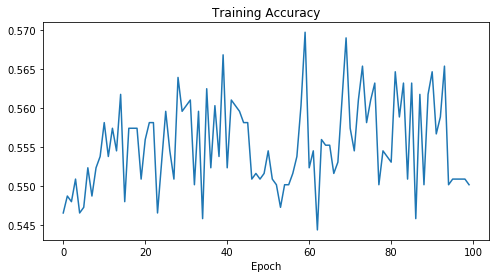

In [41]:
fig = plt.figure(figsize=[8, 4])
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

## Model Testing

In [42]:
test_acc = model.evaluate(X_test, y_test, verbose=False)[1]
print('Testing Accuracy:', test_acc)

Testing Accuracy: 0.53896105


BOOM! TIME TO MAKE SOME MONEY

# Trading Time

In [44]:
  # USD

In [53]:
X_holdout.shape, y_holdout.shape

((100, 100, 5), (100, 5))

In [79]:
money = 1000
output = []
buys, sells = 0, 0
for day, data in enumerate(zip(X_holdout, y_holdout)):
    history, _open, close = data[0], data[1][0], data[1][3]
    pred = model.predict(np.reshape(history, (1, history.shape[0], history.shape[1])))
    if pred > 0.5:
        buys += 1
        money = close/_open * money
    else:
        sells += 1
    output.append(money)

In [80]:
buys, sells

(100, 0)

Seeing as we are buying every day then it will just follow the BTC price..... Need to fix class imbalance

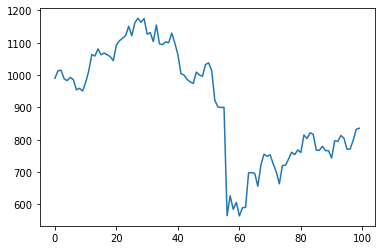

In [73]:
plt.plot(output)

In [74]:
price = y_holdout[:,3]

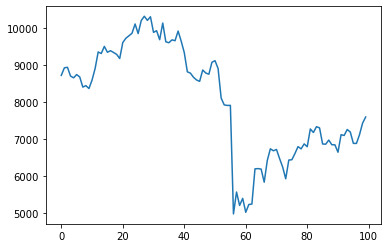

In [77]:
plt.plot(price)